To-do:
Inputs: depth, ssh, sst, time?, lat?, long?
outputs: temp, sal


In [1]:
import numpy as np
import pandas as pd
import mat73
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Disable GPU

2023-07-13 12:51:10.150597: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
input_folder = 
# Julian time is weird
# epoch_start = datetime.datetime(0000, 1, 1)

# ADT_1 = mat73.loadmat(          'ADT_20220920.mat'          , use_attrdict=True) 
# ADT_noseason = mat73.loadmat(   'ADT_noseason_20220920.mat' , use_attrdict=True) 
ARGO = mat73.loadmat(           'ARGO_GoM_20220920.mat'     , use_attrdict=True) 
# LoopCur = loadmat(              'LoopCurrentRings_edges.mat'    )

print(ARGO.keys())
# dict_keys(['ADT_loc', 'ADTnoseason_loc', 'LAT', 'LON', 'PRES', 'RHO', 'SAL', 'SH1950', 'SIG', 'SPICE', 'TEMP', 'TIME'])

# # Separate and display data from ARGO file
# print('ADT_loc', np.shape(ARGO.ADT_loc))
# print('ADTnoseason_loc', np.shape(ARGO.ADTnoseason_loc))
# print('LAT', np.shape(ARGO.LAT))
# print('LON', np.shape(ARGO.LON))
# print('PRES', np.shape(ARGO.PRES))
# print('RHO', np.shape(ARGO.RHO))
# print('SAL', np.shape(ARGO.SAL))
# print('SH1950', np.shape(ARGO.SH1950))
# print('SIG', np.shape(ARGO.SIG))
# print('SPICE', np.shape(ARGO.SPICE))
# print('TEMP', np.shape(ARGO.TEMP))
# print('TIME', np.shape(ARGO.TIME))

# ADT_loc (4890,)
# ADTnoseason_loc (4890,)
# LAT (4890,)
# LON (4890,)
# PRES (2001, 4890)
# RHO (2001, 4890)
# SAL (2001, 4890)
# SH1950 (4890,)
# SIG (2001, 4890)
# SPICE (2001, 4890)
# TEMP (2001, 4890)
# TIME (4890,)

In [2]:
# type(ARGO)
# # pd.dataframe(ARGO.LAT)
# argo_dict = {
#     'ADT_loc': ARGO['ADT_loc'],
#     'ADTnoseason_loc': ARGO['ADTnoseason_loc'],
#     'LAT': ARGO['LAT'],
#     'LON': ARGO['LON'],
#     # 'PRES': ARGO['PRES'],
#     # 'RHO': ARGO['RHO'],
#     # 'SAL': ARGO['SAL'],
#     # 'SH1950': ARGO['SH1950'],
#     # 'SIG': ARGO['SIG'],
#     # 'SPICE': ARGO['SPICE'],
#     # 'TEMP': ARGO['TEMP'],
#     'TIME': ARGO['TIME']
# }

# df = pd.DataFrame.from_dict(argo_dict)

# df.describe()




In [3]:
## Data reduction: lower resolution (5m) + remove profiles w/ NaNs
# we know the first 5m and the last 200m are the most problematic, so we prune them
# Extract the relevant arrays from the ARGO variable
# print(ARGO.PRES[:,0]) # from 0 to 2000m
pres = np.arange(5, 1800, 5, dtype=int) #halve the resolution, also seves as index
sal = ARGO.SAL[pres,:]
temp = ARGO.TEMP[pres,:]

# Julian time is weird, so we're not using it for now
# DATE1 = epoch_start + datetime.timedelta(days=ARGO.TIME[0])
# print(DATE1)

# print(np.max(pres))

# data contains NaN values, cleaning...
nan_index = np.logical_or(np.isnan(sal).any(axis=0), np.isnan(temp).any(axis=0))

# print(np.sum(nan_index))

sal = sal[:, ~nan_index]
# print(np.shape(sal))

temp = temp[:, ~nan_index]
lat = ARGO.LAT[~nan_index]
lon = ARGO.LON[~nan_index]
ssh = ARGO.SH1950[~nan_index]

sst = np.mean(temp[:1,:],axis=0) # Average the temperature of the first 10m?
print("pres size: ", np.shape(pres))

# Concatenate the input arrays into a single 2D array
X = np.column_stack((ssh, sst))

# Reshape the output arrays into a 2D array
y = np.column_stack((temp.T, sal.T))

# print(np.isnan(X).any())
# print(np.isnan(y).any())

print(np.shape(X))
print(np.shape(y))



pres size:  (359,)
(4878, 2)
(4878, 718)


In [4]:
# Define the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Find the indices of rows without NaN values
valid_idx = np.where(~np.isnan(X).any(axis=1))[0]

# Select a random subset of the valid rows
np.random.seed(42)  # set random seed for reproducibility
subset_idx = np.random.choice(valid_idx, size=2000, replace=False)

# Split the selected subset into training, validation, and testing sets
X_subset = X[subset_idx]
y_subset = y[subset_idx]
X_train, X_val_test, y_train, y_val_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)


# Normalize the input data using z-score normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define the neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2001*2, activation=None),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(718, activation=None)
])


# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model with progress indicator
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[tensorboard_callback], verbose=2)

# Evaluate the model
mse_test = model.evaluate(X_test, y_test)

# Use the model for predictions
X_new = np.array([[2.5, 20.0]])  # example input
X_new = scaler.transform(X_new)
y_pred = model.predict(X_new)

# Save the model
model.save('model.h5')


# # Split the dataset into training, validation, and testing sets
# X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# # Normalize the input data using z-score normalization
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# # Define the log directory for TensorBoard
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# # Define the TensorBoard callback
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# # Define the neural network architecture
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(2001*2, activation=None),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(4002, activation=None)
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mse')

# # Train the model with progress indicator
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[tensorboard_callback])

# # Evaluate the model
# mse_test = model.evaluate(X_test, y_test)

# # Use the model for predictions
# X_new = np.array([[2.5, 20.0]])  # example input
# X_new = scaler.transform(X_new)
# y_pred = model.predict(X_new)

# # Save the model
# model.save('model.h5')



(1600, 2)
(1600, 718)
(200, 2)
(200, 718)
(200, 2)
(200, 718)


2023-04-02 23:44:57.622237: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/50
50/50 - 3s - loss: 255.3474 - val_loss: 40.5707 - 3s/epoch - 56ms/step
Epoch 2/50
50/50 - 2s - loss: 22.2984 - val_loss: 5.9027 - 2s/epoch - 38ms/step
Epoch 3/50
50/50 - 2s - loss: 2.4850 - val_loss: 1.1179 - 2s/epoch - 37ms/step
Epoch 4/50
50/50 - 2s - loss: 1.0165 - val_loss: 0.8406 - 2s/epoch - 41ms/step
Epoch 5/50
50/50 - 2s - loss: 0.7596 - val_loss: 0.5901 - 2s/epoch - 40ms/step
Epoch 6/50
50/50 - 2s - loss: 0.4726 - val_loss: 0.3135 - 2s/epoch - 40ms/step
Epoch 7/50
50/50 - 2s - loss: 0.2643 - val_loss: 0.1798 - 2s/epoch - 42ms/step
Epoch 8/50
50/50 - 2s - loss: 0.1819 - val_loss: 0.1456 - 2s/epoch - 37ms/step
Epoch 9/50
50/50 - 2s - loss: 0.1502 - val_loss: 0.1348 - 2s/epoch - 46ms/step
Epoch 10/50
50/50 - 2s - loss: 0.1358 - val_loss: 0.1232 - 2s/epoch - 35ms/step
Epoch 11/50
50/50 - 2s - loss: 0.1210 - val_loss: 0.1063 - 2s/epoch - 40ms/step
Epoch 12/50
50/50 - 2s - loss: 0.1112 - val_loss: 0.1055 - 2s/epoch - 42ms/step
Epoch 13/50
50/50 - 2s - loss: 0.1051 - val_l

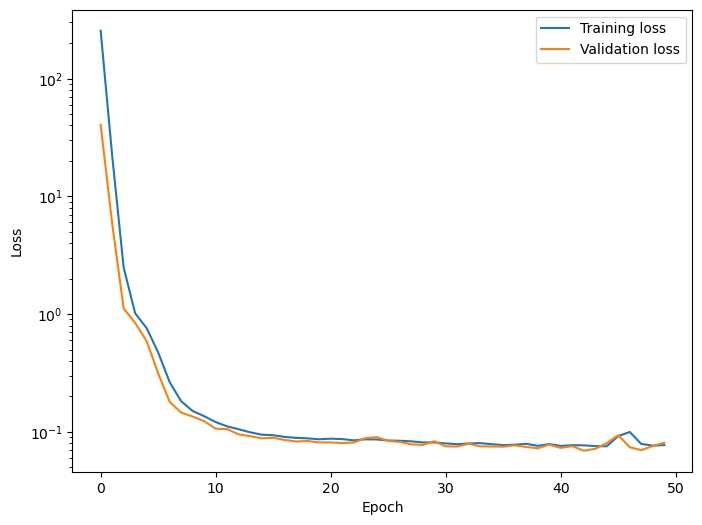

7/7 [==============================] - 0s 4ms/step
(200, 718)
(200, 718)
(359,)


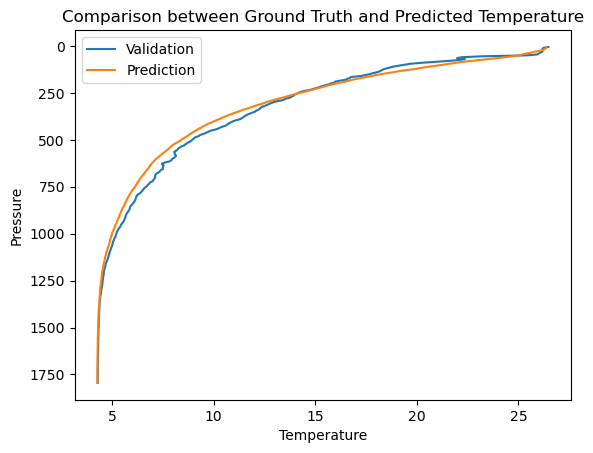

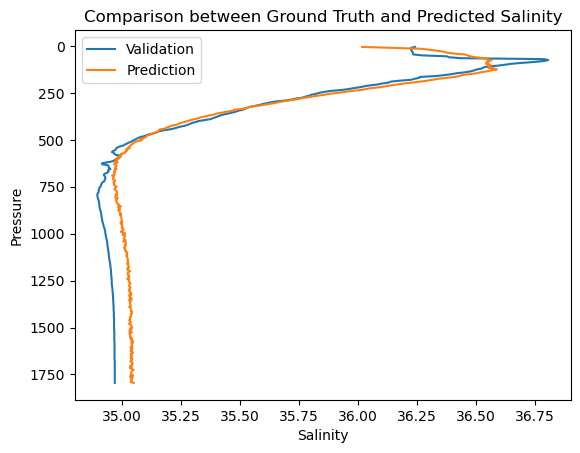

7/7 [==============================] - 0s 5ms/step - loss: 0.0808
MSE on validation set: 0.08078046143054962


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate predictions on validation set
y_pred = model.predict(X_val)

print(np.shape(y_val))
print(np.shape(y_pred))
print(np.shape(pres))




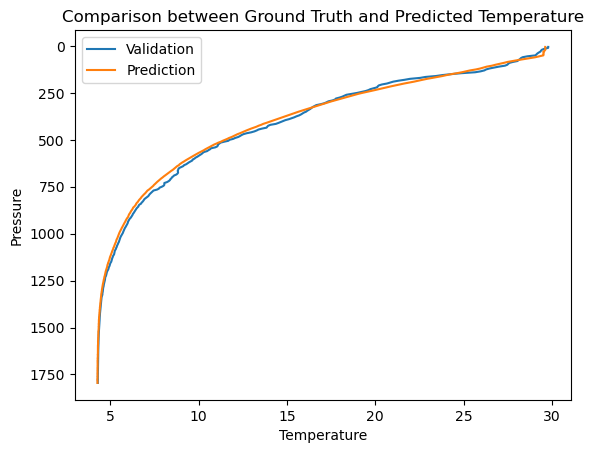

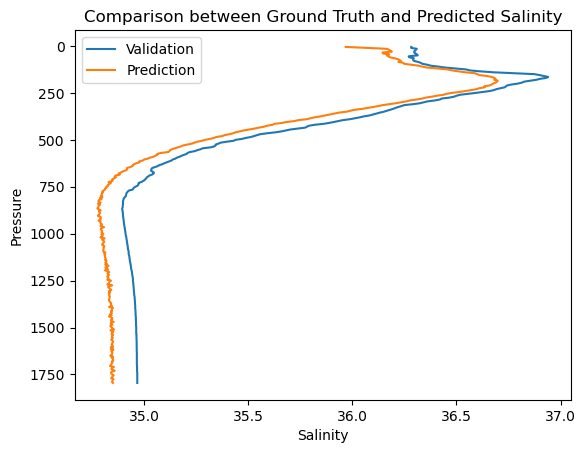

7/7 [==============================] - 0s 6ms/step - loss: 0.0808
MSE on validation set: 0.08078046143054962


In [8]:
value = 0

widgets.IntSlider(
    value=0,
    min=0,
    max=200,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

widgets.IntSlider()

# Plot comparison between predictions and ground truth
plt.plot(y_val[value,:359], pres, label='Validation')
plt.plot(y_pred[value,:359], pres, label='Prediction')
plt.title('Comparison between Ground Truth and Predicted Temperature')
plt.gca().invert_yaxis()
plt.ylabel('Pressure')
plt.xlabel('Temperature')
plt.legend()
plt.show()

# Plot comparison between predictions and ground truth
plt.plot(y_val[value,359:], pres, label='Validation')
plt.plot(y_pred[value,359:], pres, label='Prediction')
plt.title('Comparison between Ground Truth and Predicted Salinity')
plt.gca().invert_yaxis()
plt.ylabel('Pressure')
plt.xlabel('Salinity')
plt.legend()
plt.show()

# Calculate and print mean squared error on validation set
mse_val = model.evaluate(X_val, y_val)
print('MSE on validation set:', mse_val)